In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

import adnet.library as lib
%matplotlib notebook

# Kinetic Analysis
Author: Vito Zanotelli

This notebook reproduces the amplitude and peaktime analysis plots (Fig. 4i , Supplementary Fig. 14). To rerun the code, a "bindat" file from the "Main analysis" example using all data needs to be generated first.

The rationale behind this analysis is that we observed lots  of 'shapes'/relationships between the overexpression and signaling molecules. We argue that these shapes represent overexpression dependent changes in signaling strenght, represented by amplitude, and signaling dynamics, here measured by peaktime.

The challenge in this analysis is that a) we have not many timepoints b) we can have outliers (e.g. transfection only very weak) that will strongly affect amplitude and peaktime.
Thus many things are computed in a quite restrictive and outlier robust way.

Please note that for the figures in the publication the 'spillover' induced relationships (described in "Systematic spillover exclusion" were removed.

In [2]:
fn_bindat = "../example/example_output/main_full/bindat"
plot_folder = '../example/example_output/main_full/'
bin_stat = 'median'
thresh_amp = np.log2(3)

Load the data

In [3]:
bin_dat = pd.read_pickle(fn_bindat)

## Amplitude Analysis

This part looks at the changes in amplitude (as fold change) upon EGF stimulation over 10 levels of overexpression represented by 10 bins.

Get the median of the bin in untransformed counts:

In [4]:
sel_bindat = bin_dat[bin_dat['bin_dat_sigfil_any']][bin_stat].copy()
sel_bindat = sel_bindat.stack('bin')
sel_bindat.index = sel_bindat.index.droplevel(['row_col', 'perturbation', 'origin'])
sel_bindat = sel_bindat.unstack('timepoint')
sel_bindat = sel_bindat.apply(lambda x: lib.transform_arcsinh(x, reverse=True))

Get the direction of change using the area under the curve using the trapezoid rule:

In [5]:
aucs = np.trapz(sel_bindat.sub(sel_bindat[0], axis=0),axis=1,x=sel_bindat.columns)

Calculate the amplitude as fold change to the first timepoint:

In [6]:
sel_bindat = sel_bindat.div(sel_bindat[0], axis='index')
sel_bindat.drop(0, axis=1, inplace=True)
sel_bindat = sel_bindat.apply(np.log2)

peak_dat = sel_bindat.apply(lambda x: x*np.sign(aucs), axis =0).apply(lambda x: x.max(), axis=1)
peak_dat = peak_dat * np.sign(aucs)
peak_dat_mat = peak_dat.unstack(['experiment', 'marker', 'target'])

Calculate the amplitude fold change as the difference between the 90 and 10 percentile in log space. As there are 10 bins, this corresponds to the second highest to the second lowest amplitude in the bins, which gives some robustness.

In [7]:
peak_dat_d_ampl = peak_dat_mat.apply(lambda x: np.abs((np.percentile((x),90)-np.percentile((x),10))), axis=0)

peal_dat_issig = peak_dat_d_ampl > thresh_amp
peak_dat_d_ampl = peak_dat_d_ampl.groupby(level=['marker', 'target']).transform(np.median)

/home/vitoz/.virtualenvs/adnetfinal2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
/home/vitoz/.virtualenvs/python2_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in absolute
  if __name__ == '__main__':


Plot the number "hits" for amplitude changes when taking different thresholds in the log2 space.  

<IPython.core.display.Javascript object>


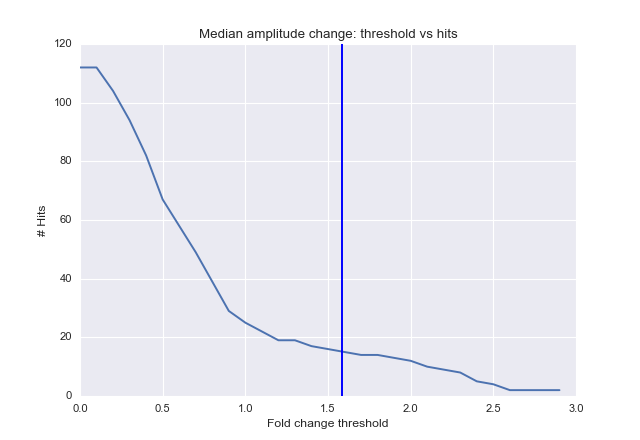

In [8]:
p = plt.figure()
tplt =peak_dat_d_ampl.groupby(level=['marker', 'target']).median()
cuo = np.array([(i, np.sum(tplt> i)) for i in np.arange(0, 3, 0.1)])
plt.plot(cuo[ :,0], cuo[:, 1])
plt.title('Median amplitude change: threshold vs hits')
plt.xlabel('Fold change threshold')
plt.ylabel('# Hits')
plt.axvline(thresh_amp)

-> as there was a slight plateau, the threshold was chosen as 3 fold amplitude change (log2(3))

Wrangle the data and sort it to be able to plot it nicely

In [9]:
fil = peak_dat_d_ampl > thresh_amp
peak_dat_fil = peak_dat_mat.loc[:, fil].copy()
peal_dat_issig = peal_dat_issig[fil]
plot_mat = peak_dat_mat.copy()
peak_dat_fil_abs = abs(peak_dat_fil.stack(['experiment', 'marker', 'target']))
fil = peak_dat_fil_abs.groupby(level=['experiment','marker','target']).transform(lambda x: x == np.max(x))
max_bin =peak_dat_fil_abs.loc[fil == 1]
# identify maximum bin
max_bin = max_bin.reset_index('bin', drop=False)
max_bin['bin'] = max_bin['bin'].groupby(level=['marker', 'target']).transform(lambda x: np.mean(x))
#
# max_bin['n_rep'] = max_bin['bin'].groupby(level=['marker', 'target']).transform(lambda x: len(x))
# max_bin = max_bin[max_bin['n_rep'] > 1]
peak_dat_fil = peak_dat_fil.transpose()
plot_mat = plot_mat.transpose()
max_bin.reset_index(['experiment', 'marker', 'target'], inplace=True, drop=False)
max_bin.set_index(['bin', 'marker', 'target', 'experiment'], inplace=True)
max_bin.sort_index(inplace=True)
max_bin.reset_index(inplace=True, drop=False)
max_bin.set_index(['marker', 'target'],inplace=True, drop=False)
plot_mat.reset_index('experiment',inplace=True, drop=True)
peal_dat_issig.reset_index('experiment',inplace=True, drop=True)
plot_mat = plot_mat.loc[max_bin.index.unique()]
peal_dat_issig = peal_dat_issig.loc[max_bin.index.unique()]


<IPython.core.display.Javascript object>


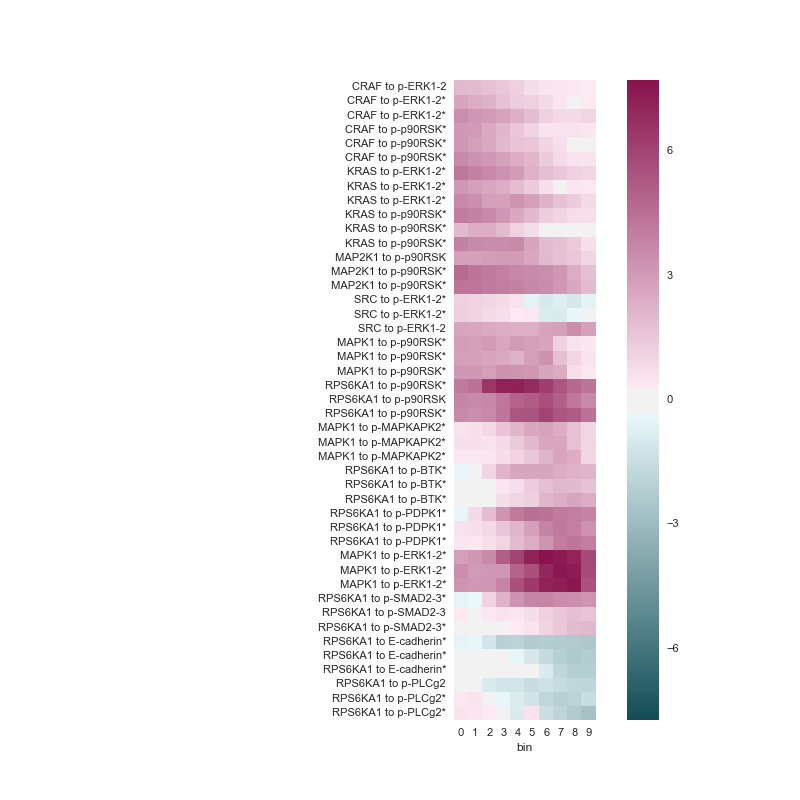

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5]),
 <a list of 45 Text yticklabel objects>)

In [10]:
labels = list()
for mark, target, sig in zip(plot_mat.index.get_level_values('marker'),plot_mat.index.get_level_values('target'), peal_dat_issig):
    if sig:
        labels.append(mark+' to '+ target+'*')
    else:
        labels.append(mark+' to '+ target)
plot_mat.index = labels
sns.set(font_scale=1)
cmap_bg = mpl.colors.LinearSegmentedColormap.from_list(
    'custom',[(0,'lightsteelblue'),(1, 'lightsteelblue')])
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True, center='light')
p = plt.figure(figsize=(10,10))
sns.heatmap(np.ones(np.shape(plot_mat)), square=True, cmap=cmap_bg, cbar=False)
sns.heatmap(plot_mat, cmap=cmap,square=True)
plt.yticks(rotation=0) 

Trying to plot it nicer by normalizing it to the strongest bin:

<IPython.core.display.Javascript object>


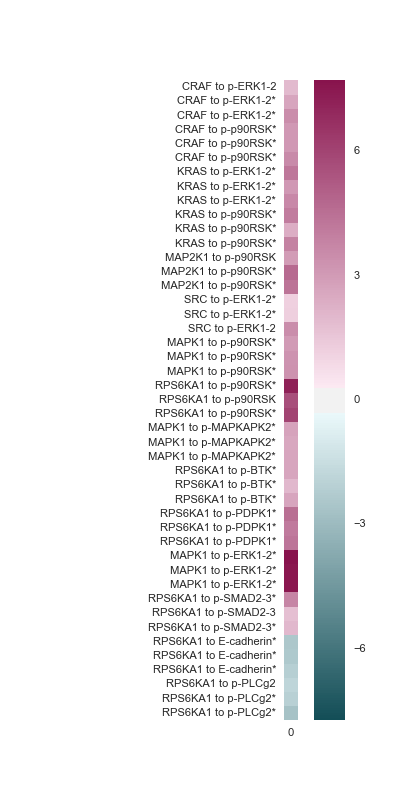

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5]),
 <a list of 45 Text yticklabel objects>)

In [11]:
p = plt.figure(figsize=(5,10))
sns.heatmap(pd.DataFrame(plot_mat.apply(lambda x: max(x, key=abs), axis=1)), cmap=cmap,square=True)
plot_mat = plot_mat.apply(lambda x: x/np.max(abs(x)), axis=1)
plt.yticks(rotation=0) 

-> This is the 'legend' to relate the normalized fold changes (Bellow) to real fold changes.

<IPython.core.display.Javascript object>


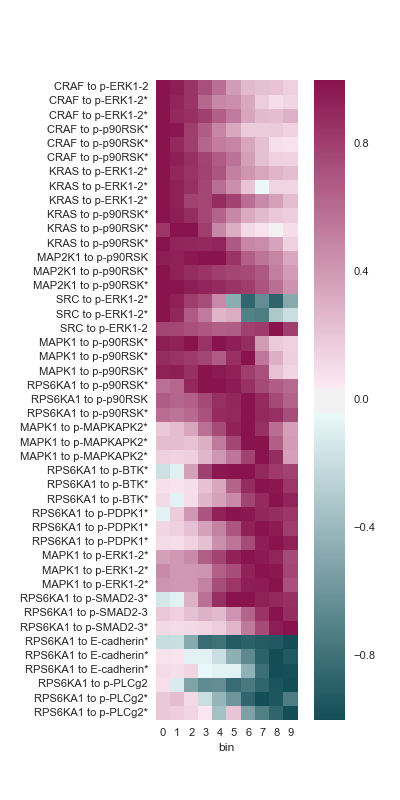

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5]),
 <a list of 45 Text yticklabel objects>)

In [12]:
p = plt.figure(figsize=(5,10))
sns.heatmap(np.zeros(np.shape(plot_mat)), square=True, cmap=cmap_bg, cbar=False)
sns.heatmap(plot_mat, cmap=cmap,square=True)
plt.yticks(rotation=0) 

-> This is the basis for Fig. 4i
Rows have been rearanged and spillover affected channels-overexpression pairs have been removed using photoshop.

## Peaktime analysis


In [13]:
sel_bindat = bin_dat[bin_dat['bin_dat_sigfil_any']][bin_stat].copy()
sel_bindat = sel_bindat.stack('bin')
sel_bindat.index = sel_bindat.index.droplevel(['row_col', 'perturbation', 'origin'])
sel_bindat = sel_bindat.unstack('timepoint')
sel_bindat = sel_bindat.apply(lambda x: lib.transform_arcsinh(x, reverse=True))

Replace NA with timepoint zero and find the peaktime.

In [14]:
sel_bindat = bin_dat[bin_dat['bin_dat_sigfil_any']][bin_stat].copy()
sel_bindat = sel_bindat.stack('bin')
sel_bindat.index = sel_bindat.index.droplevel(['row_col', 'perturbation', 'origin'])
sel_bindat = sel_bindat.unstack('timepoint')
sel_bindat = sel_bindat.apply(lambda x: lib.transform_arcsinh(x, reverse=True))

# replace na with timepoint zero
# get direction by auc
aucs = np.trapz(sel_bindat.sub(sel_bindat[0], axis=0).fillna(0),axis=1,x=sel_bindat.columns)
peak_bindat = sel_bindat.apply(lambda x: x*np.sign(aucs), axis =0)

peak_bindat = peak_bindat.stack()
fil = peak_bindat.groupby(level=['experiment', 'bin','marker','target']).transform(lambda x: x == np.max(x))
peak_bin =peak_bindat.loc[fil == 1]

peak_bin = peak_bin.reset_index(level='timepoint',drop=False)

# convert timepoints to rank numbers
# uni_tp = peak_bin['timepoint'].unique()
# uni_tp.sort()
# tpd_dict = dict(zip(uni_tp, range(len(uni_tp))))
# peak_bin['timepoint'] = [tpd_dict.get(t) for t in peak_bin['timepoint']]
peak_bin = peak_bin['timepoint'].groupby(level=['bin', 'marker', 'target', 'experiment']).mean()

peak_bin = peak_bin.unstack(level='bin')


peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target','experiment'], inplace=True)
max_bin.reset_index(drop=True, inplace=True)
max_bin.set_index(['marker', 'target','experiment'], inplace=True)
amplitude_peak_bin = peak_bin.loc[max_bin.index.unique()]

<IPython.core.display.Javascript object>


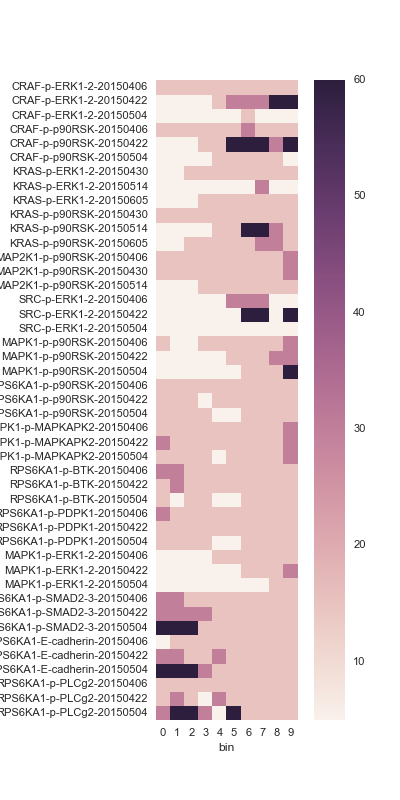

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5]),
 <a list of 45 Text yticklabel objects>)

In [15]:
p = plt.figure(figsize=(5,10))
sns.heatmap(amplitude_peak_bin,square=True)
plt.yticks(rotation=0) 

Make it more robust to look for monotonic increase/decrease

In [17]:
# check for monotonic increase/decrease
def increasing(L):
    return not(all(x == L[0] for x in L)) and all(x<=y for x, y in zip(L, L[1:]))

def decreasing(L):
    return not(all(x == L[0] for x in L)) and all(x>=y for x, y in zip(L, L[1:]))

peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)
fil = peak_bin.apply(lambda x: increasing(x), axis=1)
sig = peak_bin[fil]

Minimum in 2 replicates

In [18]:
# min in 2 replicates
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig_incr = sig[sig >1]

fil = peak_bin.apply(lambda x: decreasing(x), axis=1)
sig = peak_bin[fil]

# min in 2 replicates
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig = sig[sig >1]

sig = sig.append(sig_incr)

peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target'], inplace=True)
all_mon_peak_bin = peak_bin.loc[sig.index.unique()]

all_mon_peak_bin.reset_index(drop=False, inplace=True)
all_mon_peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)

peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)
fil = peak_bin.apply(lambda x: increasing(x) , axis=1)
sig = peak_bin[fil]

# min in 2 replicates
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig1 = sig[sig >1]

fil = peak_bin.apply(lambda x: decreasing(x), axis=1)
sig = peak_bin[fil]

# min in 2 replicates
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig2 = sig[sig >1]

sig = sig1.append(sig2)

peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target'], inplace=True)
all_mon_peak_bin = peak_bin.loc[sig.index.unique()]

all_mon_peak_bin.reset_index(drop=False, inplace=True)
all_mon_peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)

<IPython.core.display.Javascript object>


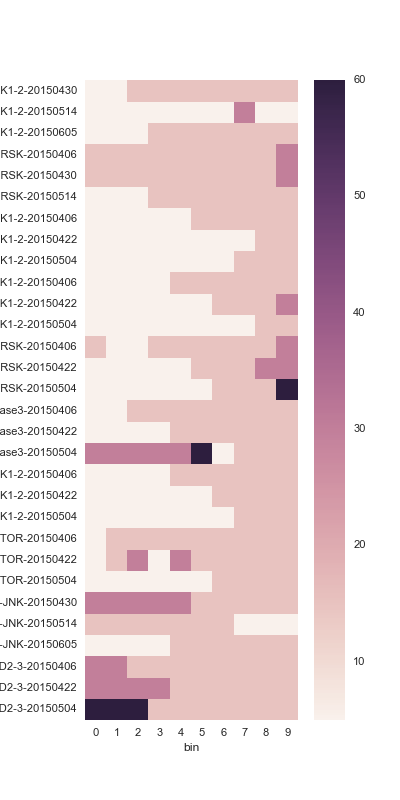

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5]), <a list of 30 Text yticklabel objects>)

In [19]:
p = plt.figure(figsize=(5,10))
sns.heatmap(all_mon_peak_bin, square=True)
plt.yticks(rotation=0) 

Look for kinetics with strong amplitudes (>3 fold) in at least 2 replicates

In [20]:
# onlty look at the ones with an amplitude of more than 3 fold
tresh = np.log2(3)
fil_bindat = sel_bindat.copy()
fil_bindat = fil_bindat.div(fil_bindat[0],axis=0).apply(np.log2)
fil_bindat = fil_bindat.apply(lambda x: x*np.sign(aucs), axis =0)
fil_bindat = fil_bindat[fil_bindat.apply(lambda x: np.max(x) > tresh, axis=1)]
fil_bindat.reset_index(drop=False, inplace=True)
fil_bindat.set_index(['marker', 'target', 'experiment'], inplace=True)
fil_idx = fil_bindat.index.unique()
peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)

strong_peak_bin = peak_bin.loc[fil_idx].copy()
fil = strong_peak_bin.apply(lambda x: increasing(x) , axis=1)
sig = strong_peak_bin[fil]

# min in 2 replicates
sig.index.names = ['marker', 'target', 'experiment']
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig1 = sig[sig >1]

fil = peak_bin.apply(lambda x: decreasing(x), axis=1)
sig = peak_bin[fil]

# min in 2 replicates
sig.index.names = ['marker', 'target', 'experiment']
sig = sig.groupby(level=['marker', 'target']).apply(len)
sig2 = sig[sig >1]

sig = sig1.append(sig2)

peak_bin.reset_index(drop=False, inplace=True)
peak_bin.set_index(['marker', 'target'], inplace=True)
all_mon_peak_bin = peak_bin.loc[sig.index.unique()]


all_mon_peak_bin.reset_index(drop=False, inplace=True)
all_mon_peak_bin.set_index(['marker', 'target', 'experiment'], inplace=True)
all_mon_peak_bin = all_mon_peak_bin.sortlevel('marker')


<IPython.core.display.Javascript object>


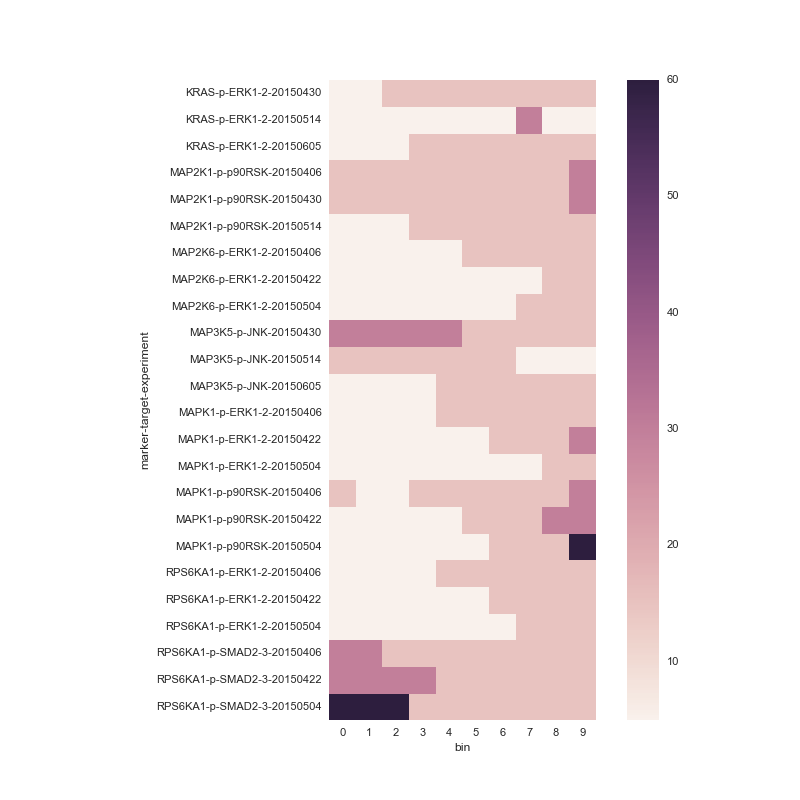

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5]),
 <a list of 24 Text yticklabel objects>)

In [21]:
p = plt.figure(figsize=(10,10))
sns.heatmap(all_mon_peak_bin, square=True)
plt.yticks(rotation=0) 

-> This is the basis for the Supplementary Figure 14 in the publication.